Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=True, num_epochs=10, n_train_stop=0, seed=1998, batch_size=64, num_workers=4, model_name='resnet18', do_scratch=False, lr=0.02, delta1=0.1, delta2=0.001, weight_decay=0.001, shuffle=True, verbose=True)

# testing different networks

In [ ]:
args = fovea.Params()
from retinoto_py import all_model_names

json_filename = args.data_cache / '13_model_comparison.json'

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    for do_mask in [True, False]:
        for dataset in fovea.all_datasets:
            for model_name in fovea.all_model_names:
                args = fovea.Params(model_name=model_name, do_mask=do_mask)
                VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
                val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)
                model = fovea.load_model(args)
                param_stats = fovea.count_parameters(model)
                total_layers = fovea.count_layers(model)
                tic = fovea.time.time()
                accuracy = fovea.get_validation_accuracy(args, model, val_loader, f"Model {args.model_name}\t dataset: {dataset}\t(do_mask={do_mask})")            
                toc = fovea.time.time()
                this_result = { 'model_name': model_name,
                                'do_mask': do_mask,
                                'dataset': dataset,
                                'accuracy': accuracy,
                                'wall_clock_time': toc-tic,
                                'total_parameters': param_stats['total_parameters'],
                                'trainable_parameters': param_stats['trainable_parameters'],
                                'total_layers': total_layers}
                all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)


Model resnet18	 dataset: full	(do_mask=True):   0%|          | 0/782 [00:00<?, ?it/s]

Model resnet50	 dataset: full	(do_mask=True):   0%|          | 0/782 [00:00<?, ?it/s]

Model resnet101	 dataset: full	(do_mask=True):   0%|          | 0/782 [00:00<?, ?it/s]

Model resnet18	 dataset: bbox	(do_mask=True):   0%|          | 0/1258 [00:00<?, ?it/s]

Model resnet50	 dataset: bbox	(do_mask=True):   0%|          | 0/1258 [00:00<?, ?it/s]

Model resnet101	 dataset: bbox	(do_mask=True):   0%|          | 0/1258 [00:00<?, ?it/s]

Model resnet18	 dataset: full	(do_mask=False):   0%|          | 0/782 [00:00<?, ?it/s]

Model resnet50	 dataset: full	(do_mask=False):   0%|          | 0/782 [00:00<?, ?it/s]

Model resnet101	 dataset: full	(do_mask=False):   0%|          | 0/782 [00:00<?, ?it/s]

Model resnet18	 dataset: bbox	(do_mask=False):   0%|          | 0/1258 [00:00<?, ?it/s]

Model resnet50	 dataset: bbox	(do_mask=False):   0%|          | 0/1258 [00:00<?, ?it/s]

Model resnet101	 dataset: bbox	(do_mask=False):   0%|          | 0/1258 [00:00<?, ?it/s]

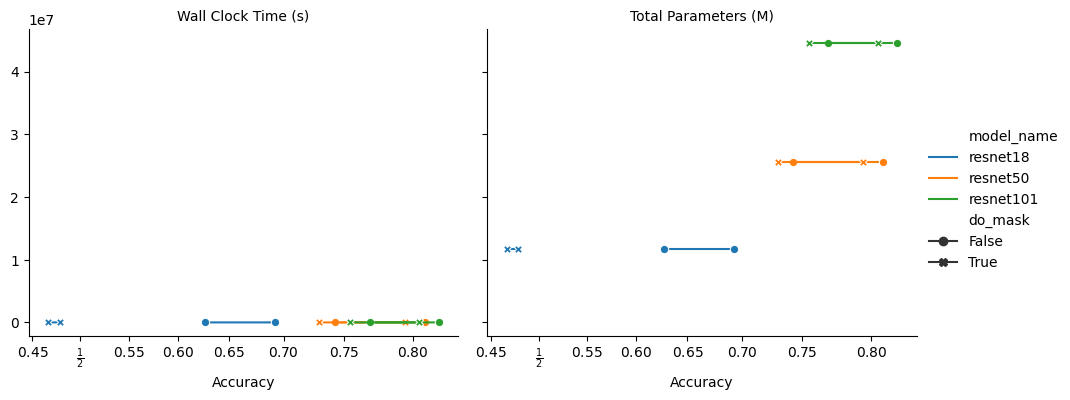

In [ ]:

# --- Step 1: Melt the DataFrame to a long format ---
# This makes plotting different y-variables much easier.
id_vars = ['model_name', 'do_mask', 'dataset', 'accuracy']
value_vars = ['wall_clock_time', 'total_parameters']
results_long = fovea.pd.melt(
    results,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='metric',
    value_name='value'
)

# Make the metric names more readable for the subplot titles
metric_name_map = {
    'wall_clock_time': 'Wall Clock Time (s)',
    'total_parameters': 'Total Parameters (M)'
}
results_long['metric_label'] = results_long['metric'].map(metric_name_map)


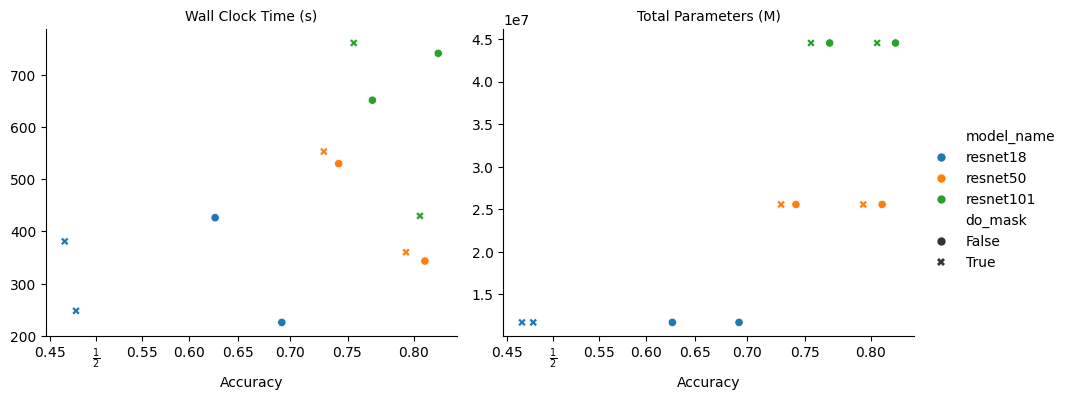

In [14]:


# --- Step 2: Create the Plot with seaborn.relplot ---
# relplot is a high-level interface that's perfect for this

g = fovea.sns.relplot(
    data=results_long,
    x='accuracy',
    y='value',
    hue='model_name',        # Different color for each model
    style='do_mask',         # Solid line for False, dashed for True
    kind='scatter',           # We want a line plot
    markers=True,            # Show markers for data points
    dashes=False,            # Let seaborn choose default dashes
    col='metric_label',      # Create subplots for each metric
    height=4,                # Height of each subplot
    aspect=1.2,               # Width of each subplot
    facet_kws={'sharey': False, 'sharex': True}

)

# --- Step 3: Final Touches ---
# Improve axis labels
g.set_axis_labels("Accuracy", "")
g.set_titles("{col_name}") # Use metric names as subplot titles

g.set(xscale='logit')
# [ax.set_xscale('logit') for ax in g.axes.flat]

# axes_list = [ax for ax in g.axes.flat]
# time_ax = axes_list[0]
# time_ax = g.axes.flat[0]
# time_ax.set_ylim(0, results_long[results_long['metric']=='wall_clock_time']['value'].max()*1.1)
# M_ax = g.axes.flat[1]
# M_ax.set_ylim(0, results_long[results_long['metric']=='total_parameters']['value'].max()*1.1)

# # Improve the legend to be more descriptive
# legend = g.legend
# new_labels = ['No Mask', 'With Mask'] # Assuming do_mask=False is plotted first
# for t, l in zip(legend.texts, new_labels):
#     t.set_text(l)
# g.legend.set_title('Masking Condition')

# # Add a main title for the whole figure
# g.fig.suptitle('Model Performance vs. Accuracy', y=1.02) # Adjust y to prevent overlap

# fovea.plt.tight_layout()
# fovea.plt.show()